In [13]:
from models import *
from dataloader import *

import pandas as pd
import numpy as np
import torch

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [7]:
device = torch.device('cuda')
T = 24
t = 1
full_edges = False
del_feature = None
path = f'./outputs/model_del_feature={del_feature}'

In [3]:
df_test = pd.read_csv('./data/df_test.csv', index_col=0)
df_test_add = np.load('./data/df_test_add.npy')

test_dataset = CustomDataset(df = df_test, 
                              df_add = df_test_add, 
                              T = T, 
                              t = t, 
                              full_edges = full_edges,
                              del_feature = del_feature,
                              device = device
                              )

In [4]:
model = TemporalGNN(
    lst_channels = [test_dataset[0][0].x.shape[1], 64, 128], # first dimension = # of features of the low-level graph
    second_dim = test_dataset[0][1].x.shape[1], # second dimension = # of features of the high-level graph
    T = T,
    t = t,
    address_start = torch.load('./data/address_start.pt').to(torch.long),
    address_end = torch.load('./data/address_end.pt').to(torch.long),
    device = device
    ).to(device)

In [8]:
model.load_state_dict(torch.load(path + '/model_best.pt'))

<All keys matched successfully>

In [9]:
with torch.inference_mode():
    lst_true = []
    lst_pred = []

    for step, (snapshot_1, snapshot_2) in enumerate(test_dataset):

        y_hat = model(snapshot_1.x, snapshot_1.edge_index, snapshot_2.x, snapshot_2.edge_index)

        lst_true.append(snapshot_1.y)
        lst_pred.append(y_hat)

    lst_true = torch.concat(lst_true, dim=1).detach().cpu().numpy()
    lst_pred = torch.concat(lst_pred, dim=1).detach().cpu().numpy()

In [10]:
df_test['pred_lgbm+'] = np.load('./data/prediction_result_v3.npy').reshape(-1, )
lst_lgbm = np.array([df['pred_lgbm+'].tolist() for _, df in df_test.groupby(['start_node_name', 'end_node_name'])])[:, T:-t]

In [11]:
df_test['pred_lgbm'] = np.load('./data/prediction_result_gnndata_v1.npy').reshape(-1, )
lst_lgbm_vanilla = np.array([df['pred_lgbm'].tolist() for _, df in df_test.groupby(['start_node_name', 'end_node_name'])])[:, T:-t]

In [14]:
print('Ours')
print('mean_absolute_error :', mean_absolute_error(lst_true, lst_pred))
print('mean_squared_error :', mean_squared_error(lst_true, lst_pred))
print('r2_score :', r2_score(lst_true, lst_pred))

Ours
mean_absolute_error : 0.2710458
mean_squared_error : 0.15600185
r2_score : 0.8166268215808752


In [16]:
print('LGBM+')
print('mean_absolute_error :', mean_absolute_error(lst_true, lst_lgbm))
print('mean_squared_error :', mean_squared_error(lst_true, lst_lgbm))
print('r2_score :', r2_score(lst_true, lst_lgbm))

LGBM+
mean_absolute_error : 0.22401215417794276
mean_squared_error : 0.12361172566495061
r2_score : 0.8540860552193031


In [17]:
print('LGBM')
print('mean_absolute_error :', mean_absolute_error(lst_true, lst_lgbm_vanilla))
print('mean_squared_error :', mean_squared_error(lst_true, lst_lgbm_vanilla))
print('r2_score :', r2_score(lst_true, lst_lgbm_vanilla))

LGBM
mean_absolute_error : 0.42603493803783954
mean_squared_error : 0.32467022167872783
r2_score : 0.6492501215611535


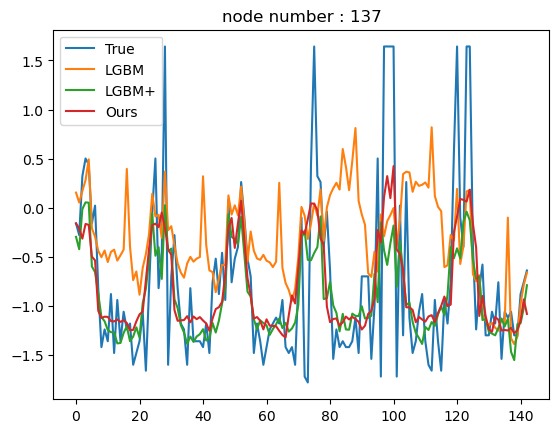

In [18]:
node_number = 137
plt.plot(lst_true[node_number, :], label='True')
plt.plot(lst_lgbm_vanilla[node_number, :], label='LGBM')
plt.plot(lst_lgbm[node_number, :], label='LGBM+')
plt.plot(lst_pred[node_number, :], label='Ours')
plt.title(f'node number : {node_number}')
plt.legend()
plt.show()